#### 라이브러리 호출

In [54]:
import logging  # to further silence deprecation warnings
import warnings

# Standard library
import joblib

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning & clustering
from sklearn import metrics, preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import umap.umap_ as umap
import hdbscan
from hdbscan.validity import validity_index

# Custom modules
from denseclus import DenseClus

# Suppress the specific FutureWarning from sklearn
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*force_all_finite.*"
)

In [36]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize": (10, 8)})

#### 데이터 호출

In [102]:
SEED = 42
np.random.seed(SEED)  # set the random seed as best we can

data_path = './data/flat-training.csv'

df = pd.read_csv(data_path)

# 결측치가 하나라도 있는 열을 제거
#df = df.dropna(axis=1)

df = df.sample(n=2000, random_state=SEED)

df.head(5)

,dog,cat,rabbit,deer,panda,koala,otter,hedgehog,squirrel,dolphin,...,blanket,button,whistle,marble,wagon,storybook,candle,clover,bubble,cookie
75721,72,0D45,NaN,2.70,0,T0,B9DE,28.2,0,1,...,A8,-5,8,0,-0.96,-73,B4,0.61,0,C16
80184,44,C09E,NaN,4.54,0,T2,B9DE,38.8,0,1,...,A6,28,14,0,-0.81,-86,B4,0.11,0,C16
19864,50,1520,NaN,3.12,-1,T1,B9DE,41.0,0,1,...,A4,-31,8,0,-0.64,32,B1,0.07,0,C8
76699,36,D668,NaN,4.37,0,T1,027A,41.0,1,1,...,A5,37,11,0,-0.94,-76,B2,0.07,0,C9
92991,31,A2FB,47.0,4.36,-2,T3,027A,39.0,0,1,...,A6,-25,2,0,-0.69,-66,B4,0.44,0,C18


In [103]:
df.dtypes

dog            int64
cat           object
rabbit       float64
deer         float64
panda          int64
              ...   
storybook      int64
candle        object
clover       float64
bubble         int64
cookie        object
Length: 80, dtype: object

In [104]:
logging.captureWarnings(True)

clf = DenseClus(random_state=SEED, umap_combine_method="intersection")

clf.fit(df)

Max of 90 is greater than threshold 25
Hashing categorical features


In [107]:
embedding = clf.mapper_.embedding_
labels = clf.evaluate()
clustered = labels >= 0

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ["cluster", "count"]
print(cnts.sort_values(["cluster"], ignore_index=True))

Coverage 0.92
Calinski-Harabasz Score: 1652.9998757669955
   cluster  count
0       -1    160
1        0    539
2        1    146
3        2    216
4        3    199
5        4    117
6        5    250
7        6    155
8        7    218


In [110]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [111]:
embedding.shape

(2000, 5)

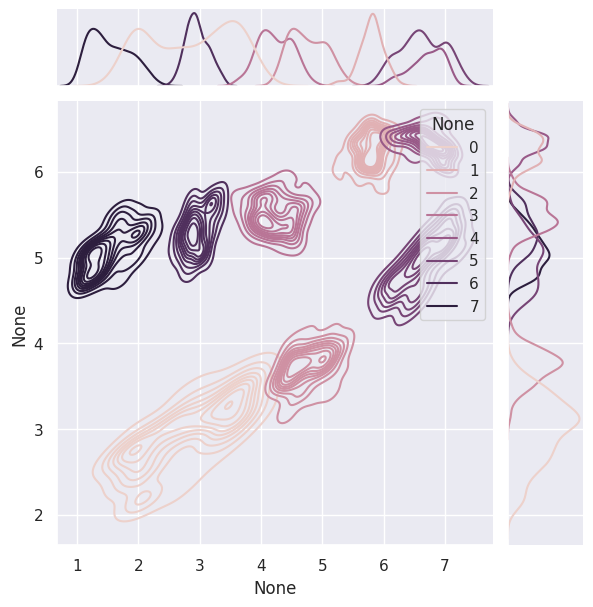

In [113]:
_ = sns.jointplot(
    x=embedding[clustered, 0], y=embedding[clustered, 1], hue=labels[clustered], kind="kde"
)

plt.show()

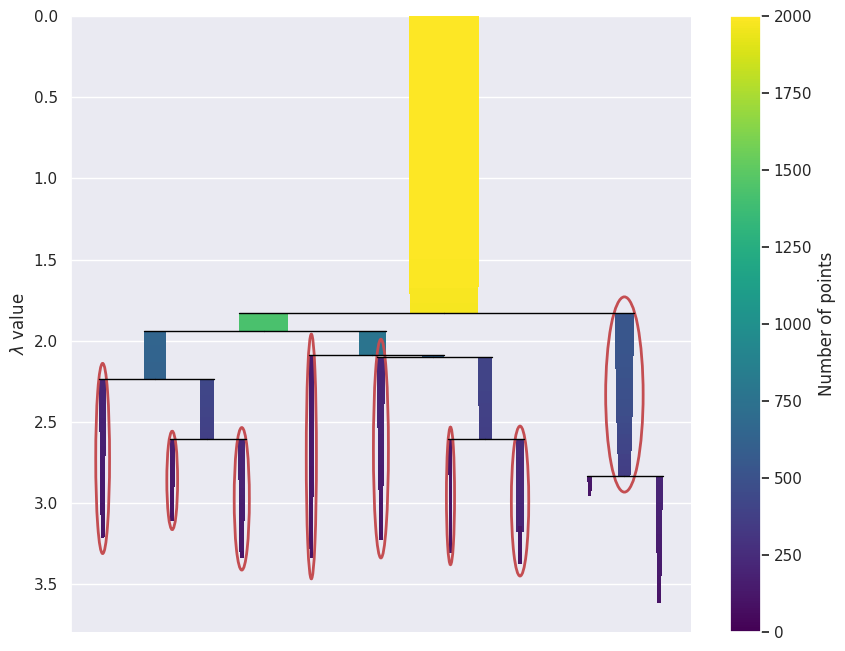

In [114]:
_ = clf.hdbscan_.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("deep", np.unique(clustered).shape[0]),
)

plt.show()

In [115]:
coverage = np.sum(clustered) / embedding.shape[0]

print(f"Coverage {coverage}")
print(f"DBCV score {clf.hdbscan_.relative_validity_}")

Coverage 0.92
DBCV score 0.34497219779805527


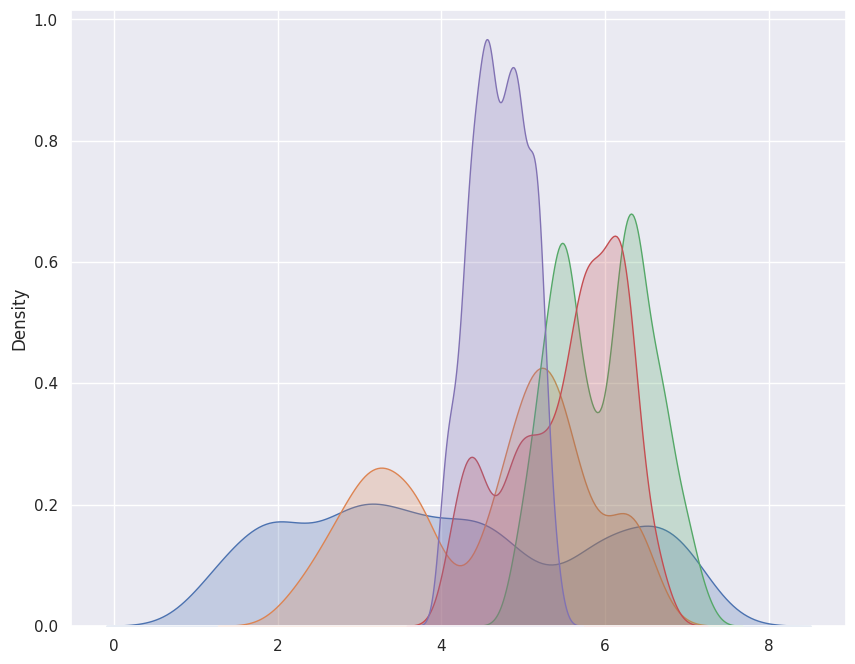

In [119]:
for i in range(len(clf.mapper_.embedding_[0])):
    sns.kdeplot(clf.mapper_.embedding_[:, i], fill=True)

plt.show()

In [117]:
from umap import validation
from warnings import filterwarnings

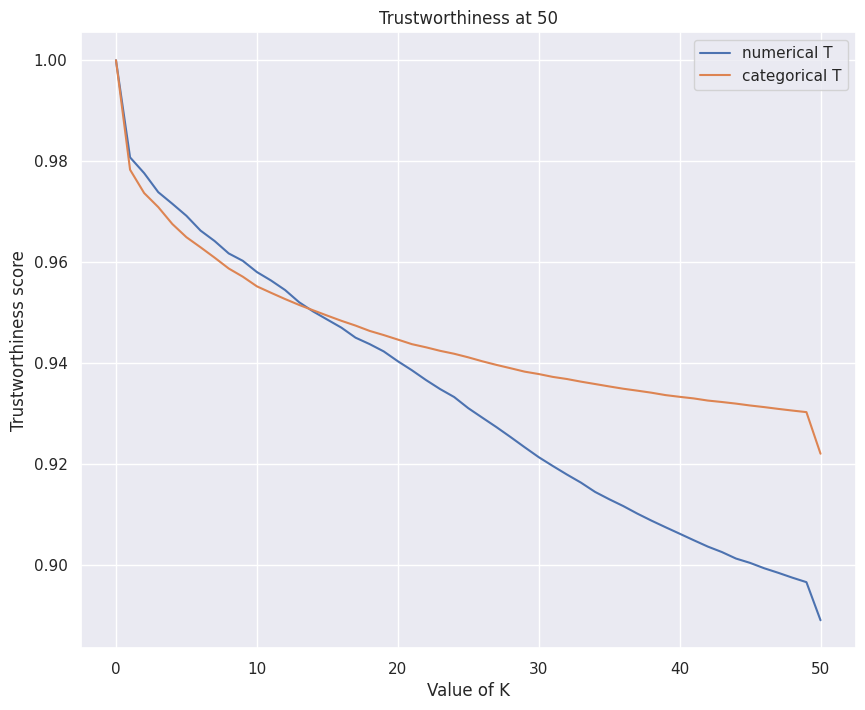

In [118]:
K = 50

# supress numba deprecation warnings from UMAP
filterwarnings("ignore")

numerical_trustworthiness = validation.trustworthiness_vector(
    source=clf.numerical_umap_._raw_data, embedding=clf.numerical_umap_.embedding_, max_k=K
)

categorical_trustworthiness = validation.trustworthiness_vector(
    source=clf.categorical_umap_._raw_data, embedding=clf.categorical_umap_.embedding_, max_k=K
)

filterwarnings("default")


plt.plot(numerical_trustworthiness)
plt.plot(categorical_trustworthiness)
plt.ylabel("Trustworthiness score")
plt.xlabel("Value of K")
plt.title(f"Trustworthiness at {K}")

plt.legend(["numerical T", "categorical T"], loc="upper right")

plt.show()